In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import sys
import time
import feather
import numpy as np
import pandas as pd
from contextlib import contextmanager
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import lightgbm as lgbm
import optuna

sys.path.append("/Users/ueda/Desktop/kaggle/mynavi/code/src/")
from logger import setup_logger, LOGGER
from trainer import train_lgbm
from util_tool import reduce_mem_usage

In [2]:
# ===============
# Constants
# ===============
DATA_DIR = "../input/"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH = os.path.join(DATA_DIR, "test.csv")
SUB_PATH = os.path.join(DATA_DIR, "sample_submit.csv")
FOLDS_PATH = "../input/mynavi_Stratifiedfold_address_under300000.feather"  #folds気をつけて
LOGGER_PATH = "log.txt"
ID_COLUMN = "id"

USE_TRAIN_THREHOLD = True
THREHOLD = 300000

EXP_ID = f"exp1_poisson_under{THREHOLD}_new"
SAVE_PATH = f'../output/{EXP_ID}'

try:
    os.mkdir(SAVE_PATH)
except:
    print("Already directory created")

Already directory created


In [3]:
# ===============
# Settings
# ===============
pd.set_option('display.max_columns', 50)

SEED = 0
N_SPLITS = 5
LOG = False

LGBM_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'poisson',    #regression, gamma, poisson gamma早すぎ
    'metric': "rmse",
    'learning_rate': 0.1,
    'max_depth': 9,
    'num_leaves': int(0.7*9**2),
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'max_bin': 255,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_child_samples': 5,
    'min_gain_to_split': 0.02,
    'min_data_in_bin': 3,
    'bin_construct_sample_cnt': 5000,
    'cat_l2': 5,
    'verbose': -1,
    'nthread': -1,
    'seed': SEED,
}
LGBM_FIT_PARAMS = {
    'num_boost_round': 50000,
    'early_stopping_rounds': 100,
    'verbose_eval': 5000,
}

use_cols = []

drop_columns = ['fold_id', 'id', 'キッチン', 'バス・トイレ', '周辺環境',
                '室内設備', '所在階', '放送・通信', '間取り',
                '築年数', '賃料', '面積', '駐車場', "路線_0", "駅_0", "方角",
                 "路線_1", "駅_1", "路線_2", "駅_2", "契約期間", '建物構造', 'アクセス', #"same_build"
]

categorical_features = ['所在_区', "catuse_駅_0", "catuse_路線_0", "所在地", "地域名", "地域_n丁目",
                        "cat_int間取り", "cat_building_height", "same_build"
]


TE_columns = [#"所在_区", #'catuse_路線_0', 'catuse_駅_0', 
              #"所在_区", #"間取りtype", #'catuse_路線_0', 'catuse_駅_0', "int築年"
              #"cat_int間取り", #"cat_building_height" # "定期借家", '一戸建て'
]

FEATURES = [
    "../code/feature_csv/base_feature1.feather",
    "../code/feature_csv/nonleak_group_feature2.feather",
    #'../code/feature_csv/nonleak_nearStation_group_feature.feather',
    #'../code/feature_csv/near_access_feature.feather',
    "../code/feature_csv/word_contain_sparse_feature.feather",
    "../code/feature_csv/access_feature.feather",
    "../code/feature_csv/address_latlng.feather",
    "../code/feature_csv/meta_features.feather"
]
setup_logger(out_file=LOGGER_PATH)

2019-11-06 21:41:25,437 - INFO - logger set up


<RootLogger root (DEBUG)>

In [4]:
# ===============
# Functions
# ===============
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s')
    
def load_feature_feather(df, filename, use_index):
    feature = feather.read_dataframe(filename)
    feature = feature.loc[use_index]
    df = pd.concat((df, feature), axis=1)
    del feature
    gc.collect()
    return df

def load_feature_csv(df, filename, use_index):
    feature = pd.csv(filename)
    feature = feature.loc[use_index]
    df = pd.concat((df, feature), axis=1)
    del feature
    gc.collect()
    return df

def modify_rent(target, df_input):
    """ id == 5776 で賃料の0が一つ多い"""
    target = np.where(df_input["id"]==5776, 120350, target)
    
    return target


def calc_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

## main

In [5]:
with timer("load data"):
    train = feather.read_dataframe(FOLDS_PATH)
    test = pd.read_csv(TEST_PATH)
    folds = train[["fold_id"]].copy()
    
    if LOG:
        y = np.log1p(train['賃料'].copy())
    else:
        y = train['賃料'].copy()
    
    if USE_TRAIN_THREHOLD:
        folds = folds[y < THREHOLD]
        folds = folds.reset_index(drop=True)
        y = y[y < THREHOLD]
        y = y.reset_index(drop=True)
    
    n_train = len(train)
    train = train.append(test).reset_index(drop=True)
    del test
    gc.collect()

2019-11-06 21:41:26,121 - INFO - [load data] done in 1 s


In [6]:
use_index = train["id"]-1
use_index.name = None

n_train = len(y)
train = train.set_index(use_index)

In [7]:
with timer("load featuers"):
    for f in FEATURES:
        train = load_feature_feather(train, f, use_index)

2019-11-06 21:41:32,026 - INFO - [load featuers] done in 6 s


In [8]:
with timer("preprocessing"):
    for c in categorical_features:
        lbl = LabelEncoder()
        lbl.fit(list(train[c].astype("str").values))
        train[c] = lbl.transform(list(train[c].astype("str").values))
        
    
    """記入ミスの修正"""
    try:
        y = modify_rent(y, train[:n_train])
    except:
        pass
    
    try:
        train.drop(drop_columns, axis=1, inplace=True)
    except:
        pass
    
    
    """importtanceで区切るなら"""
    if len(use_cols)==0:
        test = train[n_train:]
        train = train[:n_train]
    
    elif len(use_cols)>0:
        test = test[use_cols]
        train = train[use_cols]
    
    
    """外れ値分類の特量追加"""
    out = np.percentile(y, [90])
    outlin =  np.where(y > out,1,0)
    model = lgbm.LGBMClassifier().fit(train, outlin)
    train["out"] = outlin
    test["out"] = model.predict(test)
    
    
    train = reduce_mem_usage(train)
    train = train.reset_index(drop=True)
    train.to_feather(f"../features/{EXP_ID}_df.feather")
    
        
    features = list(train.columns.values)
    
    #gc.collect()
    
    categorical_features = [cat_col for cat_col in categorical_features if cat_col not in TE_columns]
    
    target_test = pd.read_csv(f'../code/feature_csv/target_encoding_test.csv')
    test[TE_columns] = target_test[TE_columns]

Memory usage of dataframe is 232.02 MB
column =  1013
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
Memory usage after optimization is: 100.42 MB
Decreased by 56.7%


2019-11-06 21:42:24,780 - INFO - [preprocessing] done in 53 s


In [9]:
with timer("train"):
    y_oof = np.empty(len(train), )
    y_test = []
    feature_importances = pd.DataFrame()

    for fold_id in range(N_SPLITS):
        with timer(f"fold {fold_id}"):
            x_train, y_train = train[folds.fold_id != fold_id], y[folds.fold_id != fold_id]
            x_val, y_val = train[folds.fold_id == fold_id], y[folds.fold_id == fold_id]
            
            #TE_feature = pd.read_csv(f'../code/feature_csv/target_encoding_groupfold{fold_id}.csv')
            #x_train[TE_columns] = TE_feature[TE_feature["fold_id"]!=fold_id][TE_columns]
            #x_val[TE_columns] = TE_feature[TE_feature["fold_id"]==fold_id][TE_columns]

            y_pred_valid, y_pred_test, train_loss, valid_loss, importances, best_iter = train_lgbm(
                x_train, y_train, x_val, y_val, test,
                categorical_features=categorical_features,
                feature_name=features,
                fold_id=fold_id,
                lgb_params=LGBM_PARAMS,
                fit_params=LGBM_FIT_PARAMS,
                model_name=EXP_ID,
                loss_func=calc_loss,
                rank=False,
                calc_importances=True
            )
            y_oof[folds.fold_id == fold_id] = y_pred_valid
            y_test.append(y_pred_test)
            feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

    feature_importances.to_csv(os.path.join(SAVE_PATH, "feature_importances.csv"), index=False)
    if LOG:
        y = np.expm1(y)
        y_oof = np.expm1(y_oof)
        y_test = np.expm1(y_test)
    score = calc_loss(y, y_oof)
    y_test = np.mean(y_test, axis=0)
    #np.save(os.path.join(SAVE_PATH, "oof.npy"), y_oof)
    #np.save(os.path.join(SAVE_PATH, "y.npy"), y)
    yoof_and_target = pd.DataFrame()
    yoof_and_target["賃料"] = y
    yoof_and_target[f'{EXP_ID}'] = y_oof
    yoof_and_target.to_csv(os.path.join(SAVE_PATH, "yoof_and_target.csv"), index=False)
    yoof_and_target.to_csv(f'../output/vs_trains/{EXP_ID}.csv', index=False)
    
    test_result = pd.DataFrame()
    test_result[f"{EXP_ID}"] = y_test
    test_result.to_csv(f'../output/test_results/{EXP_ID}.csv', index=False)
    
    LOGGER.info(f'CV={score}')

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3064]	valid's rmse: 7949.63


2019-11-06 21:46:51,916 - INFO - Best Iteration: 3064
2019-11-06 21:47:05,273 - INFO - [fold 0] done in 280 s


Training until validation scores don't improve for 100 rounds.
[5000]	valid's rmse: 8049.43
Early stopping, best iteration is:
[5116]	valid's rmse: 8049.08


2019-11-06 21:52:51,097 - INFO - Best Iteration: 5116
2019-11-06 21:53:09,976 - INFO - [fold 1] done in 365 s


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3210]	valid's rmse: 8235.08


2019-11-06 21:55:20,441 - INFO - Best Iteration: 3210
2019-11-06 21:55:30,497 - INFO - [fold 2] done in 141 s


Training until validation scores don't improve for 100 rounds.
[5000]	valid's rmse: 8228.87
Early stopping, best iteration is:
[6734]	valid's rmse: 8222.89


2019-11-06 21:59:45,240 - INFO - Best Iteration: 6734
2019-11-06 22:00:08,619 - INFO - [fold 3] done in 278 s


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4224]	valid's rmse: 8379.18


2019-11-06 22:02:55,247 - INFO - Best Iteration: 4224
2019-11-06 22:03:08,371 - INFO - [fold 4] done in 180 s
2019-11-06 22:03:08,720 - INFO - CV=66558395.077127896
2019-11-06 22:03:08,722 - INFO - [train] done in 1244 s


In [10]:
# min_child_sample  CV=395513950

In [11]:
"""if fold_id does not drop """
#(x_train[x_train["fold_id"]!=0]["fold_id"] == TE_feature[TE_feature["fold_id"]!=0]["fold_id"]).value_counts()

'if fold_id does not drop '

In [12]:
#TE_feature[TE_columns]["所在_区"].value_counts()
THREHOLD

300000

In [13]:
len(y_test)

31262

In [14]:
with timer("sub"):
    sub = pd.read_csv(SUB_PATH, header=None)
    sub[1] = y_test
    LOGGER.info(f'len sub={len(sub)}')
    sub.to_csv(os.path.join(SAVE_PATH,f'{EXP_ID}_{THREHOLD}.csv'), index=False, header=None)

2019-11-06 22:03:08,761 - INFO - len sub=31262
2019-11-06 22:03:08,857 - INFO - [sub] done in 0 s


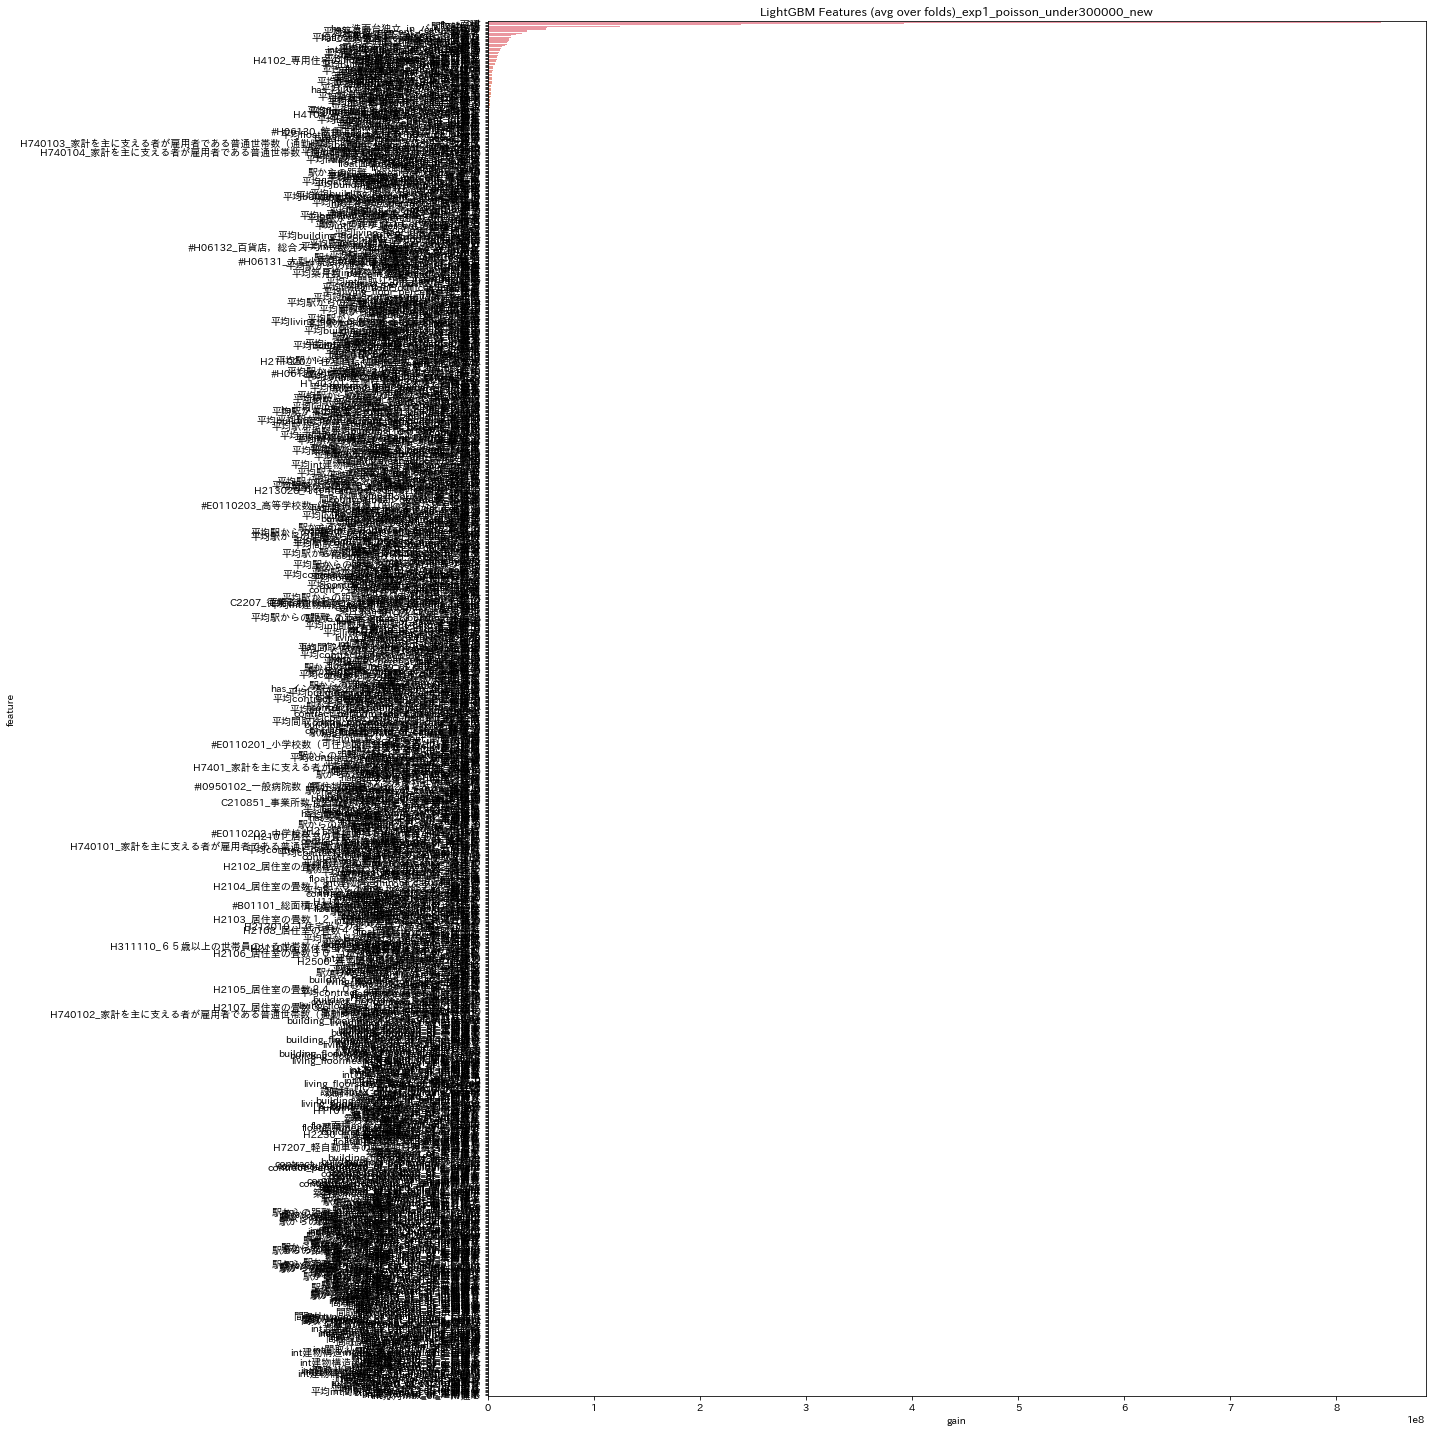

In [15]:
"""importtances visualization"""
cols = importances[["feature", "gain"]].groupby("feature").mean().sort_values(
    by="gain", ascending=False)[:1000].index

best_features = importances.loc[importances.feature.isin(cols)]
plt.figure(figsize=(20,20))
sns.barplot(x="gain", y="feature", data=best_features.sort_values(by="gain", ascending=False))
plt.title(f'LightGBM Features (avg over folds)_{EXP_ID}')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH,(f'lgbm_importances_{EXP_ID}.png')))

In [16]:
categorical_features
#TE_feature[TE_columns]

['所在_区',
 'catuse_駅_0',
 'catuse_路線_0',
 '所在地',
 '地域名',
 '地域_n丁目',
 'cat_int間取り',
 'cat_building_height',
 'same_build']

In [17]:
pd.set_option('display.max_rows', 500)
importances.sort_values("gain", ascending=False)

,feature,gain,split,fold
1012,out,8.418899e+08,343,4
17,float面積,3.922517e+08,914,4
46,間取りtype,2.384975e+08,23,4
25,所在_区,1.251409e+08,440,4
817,has_洗面台独立_in_バス・トイレ,5.563897e+07,101,4
947,catuse_駅_0,5.530095e+07,9525,4
209,平均築月数_percent_cat_int間取り,3.709655e+07,563,4
27,地域名,3.690574e+07,11540,4
169,平均float面積_percent_一戸建て,3.236108e+07,271,4
55,バス・トイレ_element_counts,2.698580e+07,403,4


In [18]:
use_cols = list(importances[importances["gain"]>10000]["feature"].values)
len(use_cols)

569

In [20]:
#yoof_and_target[yoof_and_target["賃料"] == yoof_and_target["賃料"].max()]

In [21]:
y_test

array([134692.30214771, 118630.03309733,  75376.26550449, ...,
       173805.87322574, 265209.90534623,  82590.19852343])

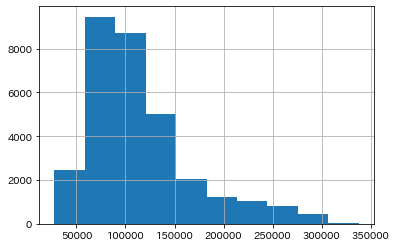

In [30]:
#test[test["out"]<300000]
pd.Series(y_test).hist()

In [36]:
(y_test>300000).sum()

100

In [71]:
one_result = pd.read_csv("../output/vs_trains/exp0_+address_poisson_outlin+meta.csv")
upper_result = pd.read_csv("../output/vs_trains/exp1_poisson_upper100000_new.csv")

In [75]:
#upper_result
one_result["upper"] = one_result["賃料"].map(upper_result.set_index("賃料").to_dict()["exp1_poisson_upper100000_new"])
one_result["under"] = one_result["賃料"].map(yoof_and_target.set_index("賃料").to_dict()["exp1_poisson_under300000_new"])

In [80]:
oof_ens = np.where(one_result["賃料"]>250000, one_result["upper"], one_result["under"])

In [87]:
a = pd.read_csv("../input/train.csv")
a["up+und_thre_is_250000"] = oof_ens

In [90]:
a[["賃料", "up+und_thre_is_250000"]].to_csv("../output/vs_trains/up+und_thre_is_250000.csv", index=False)

In [96]:
test_up = pd.read_csv("../output/exp1_poisson_upper100000_new/exp1_poisson_upper100000_new_100000.csv", header=None)

In [104]:
test_ens = np.where(sub[1]>250000, test_up[1], sub[1])

In [108]:
ens_df = pd.DataFrame(sub[0])

In [110]:
ens_df["1"] = test_ens

In [115]:
os.mkdir("../output/up+und_thre_is_250000")

In [112]:
try:
    os.mkdir("../output/up+und_thre_is_250000")
except:
    print("Already directory created")

Already directory created


In [117]:
ens_df.to_csv("../output/up+und_thre_is_250000/up+und_thre_is_250000.csv", index=False, header=None)